In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import hdf5plugin
import torch
%matplotlib inline
from crystfelparser.crystfelparser import streamfile_parser
import os

#os.environ['LD_LIBRARY_PATH'] = '/das/work/p19/p19607/.conda/testkeras/lib:/das/work/p19/p19607/ffbidx/lib64' 
import ffbidx

In [2]:
import glob

stream_files = sorted(glob.glob("../../../REDML_indx_data/kr2/processing_whole_dataset/KR2-dark3_28*.stream"))
#stream_files

### Refining Functions

In [3]:
from scipy.optimize import minimize
class refine_local:
    """Refine lattice basis using local optimization.
     
    spots: ndarray of shape (-1, 3)
        spot coordinates
    triml/trimh: low and high trim values
    niter: number of iterations
    args:
        extra named arguments to scipy.optimize.dual_annealing"""
        
    def __init__(self, spots, triml, trimh, niter=1, **args):
        """Create dual annealing refinement object
        
        Args:
            spots: (ndarray of shape (-1, 3))
                spot coordinates
            trimh: float
                trim hights value
            triml: float
                trim lows value
            iter: int
                iterations
            args:
                dual_annealing arguments"""
        self.spots = spots
        self.triml = triml
        self.trimh = trimh
        self.niter = niter
        self.args = args
        self.i = None

    def score(self, Bflat):
        """Scoring function
        
        Args:
            Bflat: ndarray of shape (9,)
                flattened lattice basis row major
        Returns:
            Distance to perfect solution"""
        B = Bflat.reshape(3,3)
        S = self.spots
        try:
            C = S @ np.linalg.inv(B.T)
        except:
            return float(self.spots.shape[0])
        Z = C.round()
        i = self.i + 1
        d = (self.trimh - self.triml) / i
        # e = np.maximum(np.minimum(np.fabs(C - Z).max(axis=1), self.triml + d), self.triml / i)
        e = np.log2(np.maximum(np.minimum(np.fabs(C - Z).max(axis=1), self.triml + d), self.triml / i))
        return e.sum()
    

        
    def __call__(self, B):
        """Refine lattice basis
        
        Args:
            B: ndarray of shape (3,3)
                lattice basis with row vectors
            threshold: float
                solution coordinate deviation allowance in percent
        Returns:
            Refined lattice basis"""
        Bflat = B.ravel()
        for self.i in range(self.niter):
            res = minimize(self.score, x0=Bflat, **self.args)
            print(f"success={res.success}, score={res.fun}, {res.message}")
            Bflat = res.x
        return res.x.reshape(3,3)

# Iterative outlier elimination
class iter_elim_lsq:
    def __init__(self, S, score, c, n):
        self.spots = S
        self.score = score # normalized cell score
        print('score =', self.score)
        self.contraction = c
        self.npoints = n
    def elim(self, B, frac):
        C = self.spots @ np.linalg.inv(B.T)
        Z = C.round()
        e = np.linalg.norm(C - Z, axis=1)
        sel = e < frac
        n = sel.sum()
        return self.spots[sel, :], Z[sel, :], n
    def __call__(self, B):
        f = self.score
        while True:
            S, Z, n = self.elim(B, f)
            if n < self.npoints:
                return B
            B = np.linalg.lstsq(Z, S, rcond=None)[0].T
            f *= self.contraction
        return B
    
# iterative fit to selected errors
class refine_ifse:
    def __init__(self, S, score, r, niter=3, minpoints=6):
        self.S = S              # spots
        self.score = score      # normalized score
        self.r = r              # retraction speed > 0 (higher = slower)
        self.niter = niter      # num iterations
        self.minp = minpoints   # select no less than so many errors
    def ZEe(self, B):
        Z = (self.S @ np.linalg.inv(B.T)).round()
        E = S - Z @ B.T
        e = np.linalg.norm(E, axis=1)
        return Z, E, e
    def refine(self, B, i):
        Z, E, e = self.ZEe(B)
        a, b = e.min(), e.max()
        t = a + (b - a) * self.score * self.r / (i + self.r)
        print(i, ':', t)
        sel = e < t
        if sel.sum() < self.minp:
            return B, False
        D = np.linalg.lstsq(Z[sel, :], E[sel, :], rcond=None)[0].T
        return B + D, True
    def __call__(self, B):
        R = B.copy()
        ok, i = True, 0
        while ok and (i < self.niter):
            R, ok = self.refine(R, i)
            i += 1
        return R

In [4]:
# Plot error statistics, calculate and return Z (approx Miller indices)
def plot_error(B, S, title, Bc=None):
    # B, Bc col vector matrices
    C = S @ np.linalg.inv(B.T)
    Z = C.round()
    E = C - Z
    e = np.linalg.norm(E, axis=1)
    alpha = .8 if not Bc is None else 1.
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
    ax[0].plot(e, alpha=alpha)
    ax[0].set_xlabel('spot')
    ax[0].set_ylabel('error')
    _ = ax[1].hist(e, bins=50, alpha=alpha)
    ax[1].set_xlabel('error')
    ax[1].set_ylabel('number of spots')
    ax[1].set_title(title)
    _ = ax[2].hist(e, bins=50, alpha=alpha, cumulative=True, histtype='step', label='sol')
    ax[2].set_xlabel('error')
    ax[2].set_ylabel('number of spots')
    if not Bc is None:
        Cc = S @ np.linalg.inv(Bc.T)
        Zc = Cc.round()
        Ec = Cc - Zc
        ec = np.linalg.norm(Ec, axis=1)
        ax[0].plot(ec, alpha=alpha-.1)
        _ = ax[1].hist(ec, bins=50, alpha=max(alpha-.3, .1))
        _ = ax[2].hist(ec, bins=50, alpha=max(alpha-.3, .1), cumulative=True, histtype='step', label='ref')
        ax[2].legend(loc='upper left')
    plt.tight_layout()

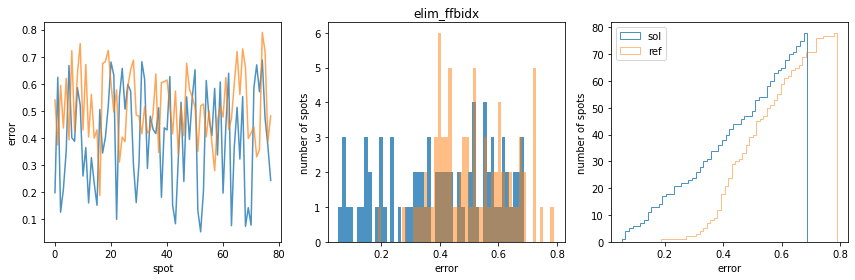

In [34]:
#plot_error(Belim_ffbidx, S, "elim_ffbidx", Bgreta)

In [5]:
def predictBraggsReflections(reciprocal_basis_vectors, 
                             vwlen=0.9998725806451613, 
                             maxhkl=30, 
                             detector_distance_m=0.200, 
                             detectorCenter=[1122.215602,1170.680571], 
                             pixelLength_m=75e-6, 
                             nx=2068, ny=2164, 
                             eps=4e-4, 
                             device='cpu'):
    """ Given a rotation matrix in the reciprocal space, predict the ideal Bragg's reflections

    Args:
        reciprocal_basis_vectors (torch.tensor): reciprocal basis vectors (a*, b*, c*)
        vwlen (float, optional): beam's wavelenght. Defaults to 0.9998725806451613.
        maxhkl (int, optional): max integer for h, k, l numbers. Defaults to 30.
        detector_distance_m (float, optional): Detector distance in m. Defaults to 0.200.
        detectorCenter (list, optional): Beam's center in pixels. Defaults to [1122.215602,1170.680571].
        pixelLength_m (float, optional): Pixels size in m. Defaults to 75e-6.
        nx (int, optional): Detector size (x direction). Defaults to 2068.
        ny (int, optional): Detector size (y direction). Defaults to 2164.
        eps (float, optional): Tolerance (correlates with the non-monocromaticity). Defaults to 3e-4.
        device (str, optional): Torch device. Defaults to 'cpu'.

    Returns:
        _type_: _description_
    """
    
    #  for now this will stay hard-coded
    beam_direction=np.array([0,0,1./vwlen])
    detectorCenter=[detectorCenter[1],detectorCenter[0]]
    
    # generate the millers grid
    rh = torch.arange(-maxhkl, maxhkl, dtype=torch.int16, device=device)
    rk = torch.arange(-maxhkl, maxhkl, dtype=torch.int16, device=device)
    rl = torch.arange(-maxhkl, maxhkl, dtype=torch.int16, device=device)
    millers = torch.stack([
        rh.repeat_interleave(len(rk)*len(rl)),
        rk.repeat(len(rh)).repeat_interleave(len(rl)),
        rl.repeat(len(rh)*len(rk)),
    ]).T
    # generate the reciprocal lattice vectors
    reciprocalPeaks = millers @ reciprocal_basis_vectors
    
    # remove the beam vector
    reciprocalPeaks -= torch.tensor(beam_direction)
    # threshold
    cond = torch.abs(torch.norm(reciprocalPeaks,dim=1)-(1/vwlen)) < eps
    reciprocalPeaks = reciprocalPeaks[cond]
    millers = millers[cond]
    
    # reflect the x-axis
    # rotation matrix
    rt = torch.tensor([
        [-1,0,0],
        [0,1,0],
        [0,0,1]], dtype=torch.double)
    reciprocalPeaks = reciprocalPeaks @ rt

    # recenter the points
    reciprocalPeaks += torch.tensor([beam_direction])
    
    # flip
    reciprocalPeaks*=torch.tensor([-1,1,1])
    projectedPeaks = reciprocalPeaks[:, [1,0]] / (reciprocalPeaks[:, -1:] - (1/vwlen)) * detector_distance_m
    # center and flip x and y
    projectedPeaks=(projectedPeaks / pixelLength_m + torch.tensor(detectorCenter, device=device))[:,[1,0]]
    # limit the points inside the detector panel
    return projectedPeaks[(projectedPeaks[:,0] > 0) & (projectedPeaks[:,0] < nx) & (projectedPeaks[:,1] > 0) & (projectedPeaks[:,1] < ny)]


def get_matching_pairs(reference, list_to_match, max_distance=20):
    '''
    given two sets of points find matching pairs 
    using linear sum assignement
    '''
    from scipy.optimize import linear_sum_assignment
    from scipy.spatial.distance import cdist
    distance_matrix = cdist(reference, list_to_match)
    row_ind, col_ind = linear_sum_assignment(distance_matrix)
    matched_idx = np.where(distance_matrix[row_ind, col_ind] < max_distance)
    return row_ind[matched_idx], col_ind[matched_idx]

def get_matching_pairs(reference, list_to_match,max_distance=20):
    '''
    given two sets of points find matching pairs
    '''
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(list_to_match)
    distances, indices = nbrs.kneighbors(reference)
    
    # Reshape the list of arrays into np.arrays
    indices=np.asarray(indices).reshape(-1)
    distances=np.asarray(distances).reshape(-1)
    
    # select pairs with distance lower than max_distance
    matched_idx=np.where(distances<max_distance)[0]
    
    return np.arange(len(reference))[matched_idx], indices[matched_idx]

def imgf_plot(img,vmax=20,figsize=(12,12)):
    '''Just plot a diffraction image using matplotlib'''
    im=np.clip(img,0,10000)
    plt.figure(figsize=figsize, dpi=80)
    imlog=np.log(im+1)
    imlog=imlog/np.max(imlog)*255
    plt.imshow(imlog,cmap="gist_yarg",vmin=0,vmax=vmax)
    plt.axis('off')
    
    
def plot_and_compare(FR, rec_cell, stream_to_compare, sample_imgs):
    '''Plot a diffraction image using matplotlib
       and on top compare two different indexing solutions
       as well as the strong spots
    '''
    
    predicted_reflections_1 = predictBraggsReflections(rec_cell.astype('float64'), 
                                     vwlen=stream_to_compare.wavelength, 
                                     maxhkl=80, 
                                     detector_distance_m=stream_to_compare.clen/1000, 
                                     detectorCenter=[stream_to_compare.beam_center_x,stream_to_compare.beam_center_y], 
                                     pixelLength_m=75e-6, 
                                     nx=2068, ny=2164, 
                                     eps=9e-4, 
                                     device='cpu')
    
    if 'reciprocal_cell_matrix' in stream_to_compare.parsed[FR].keys():
        reciprocal_cell_matrix = stream_to_compare.parsed[FR]['reciprocal_cell_matrix'] * 0.1
        predicted_reflections_2 = predictBraggsReflections(reciprocal_cell_matrix, 
                                     vwlen=stream_to_compare.wavelength, 
                                     maxhkl=80, 
                                     detector_distance_m=stream_to_compare.clen/1000, 
                                     detectorCenter=[stream_to_compare.beam_center_x,stream_to_compare.beam_center_y], 
                                     pixelLength_m=75e-6, 
                                     nx=2068, ny=2164, 
                                     eps=9e-4, 
                                     device='cpu')
    else:
        predicted_reflections_2 = None


    spots2d = stream_to_compare.get_spots_2d(FR)

    imgf_plot(sample_imgs[FR],vmax=50,figsize=(10,10))
    _ = plt.scatter(spots2d[:,0], spots2d[:,1], s=20,facecolors='none', edgecolors='r', label='spots')
    if not predicted_reflections_2 is None:
        _ = plt.scatter(predicted_reflections_2[:,0],predicted_reflections_2[:,1],s=60,facecolors='none', marker="d",edgecolors='#00FF00',label='stream')
    _ = plt.scatter(predicted_reflections_1[:,0],predicted_reflections_1[:,1],s=40,facecolors='none', marker="s",edgecolors='g',label='cell')
    # Plot the True Positive
    # Spots the are predicted from the model crystal and also detected by the spotfinder
    (matched_pred,matched_str)=get_matching_pairs(predicted_reflections_1, spots2d, max_distance=15)
    TP=spots2d[matched_str]
    if len(TP) > 0:
        _ = plt.scatter(TP[:,0],TP[:,1],s=5,fc='b',label='match')
    plt.legend()
    return matched_str


In [6]:
def score_external(S, B, trimh = 0.5):
    """Scoring function
        
        Args:
            Bflat: ndarray of shape (9,)
                flattened lattice basis row major
        Returns:
            Distance to perfect solution"""

    try:
        C = S @ np.linalg.inv(B.T)
    except:
        return float(self.spots.shape[0])
    Z = C.round()
    
    e = np.minimum(np.fabs(C - Z).max(axis=1), trimh ) + 1e-10
    
    return e.sum()

## Run indexing with local refinement

In [9]:
stream_lyso_Greta.cellpdb

array([ 41.54,  84.48, 235.56,  90.  ,  90.  ,  90.  ])

In [11]:
from tqdm import tqdm_notebook as tqdm

import os
import sys
f = open(os.devnull, 'w')
sys.stdout = f

output = {}
for i, file in enumerate(stream_files):
    stream_lyso_Greta = streamfile_parser(file)
    initial_cell = stream_lyso_Greta.cell_matrix
    initial_cell = np.linalg.inv(initial_cell).T.astype('float32')
    triml = .0
    trimh = .3
    indexer = ffbidx.indexer(1, 1, 300, 32)
    
    HC_brute_cells = []
    HC_refloc_cells = []
    HC_LBelim_cells = []
    HC_brute_scores = []

    scores_elim = []
    scores_brute = []
    scores_local = []
    
    for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):
        if 'peaks' in stream_lyso_Greta.parsed[fr].keys():
            S = stream_lyso_Greta.get_spots_3d(fr).astype('float32')
            S[:,0] = -S[:,0]
            indata = np.vstack((initial_cell.T, S)).astype('float32', order='F')
        
            Bffbidx, score = ffbidx.index(indexer, 1e-9, triml, trimh, 32*1024, 32, 1, indata)
            HC_brute_scores.append(score[0]) 
            test_score_brute = score_external(S, Bffbidx, trimh)
            scores_brute.append(test_score_brute)
            # transpose the cell before storing it
            HC_brute_cells.append(Bffbidx.T)
            ref_local = refine_local(S, triml, trimh, 2)
            Blocal = ref_local(Bffbidx)
            HC_refloc_cells.append(Blocal.T)
            test_score_local = score_external(S, Blocal, trimh)
            scores_local.append(test_score_local)
            elim = iter_elim_lsq(S, score, .8, 6)
            Belim_ffbidx = elim(Bffbidx)
            HC_LBelim_cells.append(Belim_ffbidx.T)
            test_score_elim = score_external(S, Belim_ffbidx, trimh)
            scores_elim.append(test_score_elim)
        else:
            HC_brute_scores.append(-333e7) 
            scores_brute.append(-333e7)
            scores_local.append(-333e7)
            scores_elim.append(-333e7)
            HC_refloc_cells.append([])
            HC_LBelim_cells.append([])
            
        
    output[i + 1] = {
        "HC_brute_cells": HC_brute_cells,
        "HC_refloc_cells": HC_refloc_cells,
        "HC_LBelim_cells": HC_LBelim_cells,
        "HC_brute_scores": HC_brute_scores,
        "scores_elim": scores_elim,
        "scores_brute": scores_brute,
        "scores_local": scores_local
    }

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_32591/2265758639.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fr in tqdm(sorted(stream_lyso_Greta.parsed.keys())):


  0%|          | 0/10000 [00:00<?, ?it/s]

## check how it worked

In [16]:
sample_imgs = h5py.File("/das/work/p16/p16371/MAXIV/20211201/raw/KR2/KR2-dark3/KR2-dark3_28_data_000001.h5", "r")['entry']['data']['data']
stream_lyso_Greta = streamfile_parser(stream_files[0])

array([27, 27, 42, 42, 42, 45, 45,  3,  5,  5, 11, 11, 16, 16, 20, 20, 23,
       26, 37,  9, 28, 31, 35, 39, 61, 61, 64, 71, 71, 73, 74, 79, 79,  8,
       18, 34, 68, 78, 17, 36, 29, 32, 51, 63, 66, 82, 52, 52, 52, 52, 52,
       52, 33, 33, 33, 33])

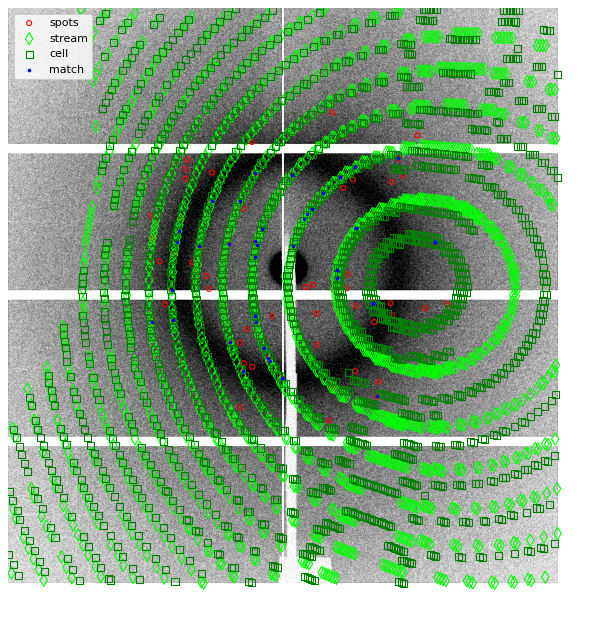

In [21]:
frame=stream_lyso_Greta.get_indexable_frames()[20]
#get_reciprocal_basis(np.linalg.inv(output[1]["HC_LBelim_cells"][frame]))
plot_and_compare(frame, output[1]["HC_brute_cells"][frame], stream_lyso_Greta, sample_imgs)

(array([72.45387197, 85.54134701, 92.56229628]),
 array([ 95.26595696, 118.67895477,  84.0647032 ]))

In [62]:
pdbcells=np.array([np.hstack([Cell(output[1]["HC_refloc_cells"][frame]).reciprocal().lengths(),Cell(output[1]["HC_refloc_cells"][frame]).reciprocal().angles()]) if output[1]["HC_refloc_cells"][frame]!= [] else [np.inf for j in range(6)] for frame in range(len(output[1]["HC_refloc_cells"]))])

/tmp/ipykernel_33783/709484251.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  pdbcells=np.array([np.hstack([Cell(output[1]["HC_refloc_cells"][frame]).reciprocal().lengths(),Cell(output[1]["HC_refloc_cells"][frame]).reciprocal().angles()]) if output[1]["HC_refloc_cells"][frame]!= [] else [np.inf for j in range(6)] for frame in range(len(output[1]["HC_refloc_cells"]))])


In [66]:
pdbcells[0], stream_lyso_Greta.cellpdb

(array([ 73.11216324,  89.82343861,  91.5092708 ,  89.42582119,
        118.41614073,  89.90250946]),
 array([ 82.1,  82.1,  89.6,  90. ,  90. , 120. ]))

In [111]:
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance

diffs=[]
for fr,pdbc in enumerate(pdbcells):
    if pdbc[0]==np.inf:
        continue
        
    cost=distance.cdist(stream_lyso_Greta.cellpdb[3:].reshape(-1,1), pdbc[3:].reshape(-1,1), 'euclidean')
    row_ind, col_ind = linear_sum_assignment(cost)
    tcell=Cell(output[1]["HC_refloc_cells"][fr][col_ind]).reciprocal()
    diffs.append(np.hstack([[fr],pdbc,np.hstack([tcell.lengths(),tcell.angles()])-stream_lyso_Greta.cellpdb]))

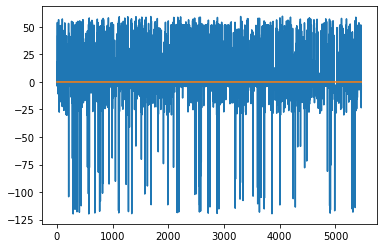

In [121]:
diffs=np.array(diffs)

_=plt.plot(diffs[:,-1])
_=plt.plot([0 for i in diffs[:,-1]])

In [119]:
diffs[np.abs(diffs[:,-1]).argsort()][:,1:7].astype(int)[-10:]

array([[ 375,   65,   71,    1,    2,    3],
       [1452,   67,  285,    4,    1,    4],
       [ 720,   89,  255,    5,    1,    5],
       [ 176,  178,   29,    7,    8,    0],
       [ 101,   89,  247,    0,    1,    2],
       [ 539,   90,  464,    9,    0,   10],
       [ 640,   88,  471,   10,    0,   10],
       [1142,   89,  838,    4,    0,    4],
       [ 762,   89,  786,    2,    0,    2],
       [1165,   89,  370,    1,    0,    1]])

In [122]:
Cell(output[1]["HC_refloc_cells"][928]).reciprocal().lengths(), Cell(output[1]["HC_refloc_cells"][928]).reciprocal().angles()

(array([1165.94248796,   89.7195138 ,  370.63503821]),
 array([1.64002237, 0.17569407, 1.65122932]))

In [124]:
np.array(Cell(output[1]["HC_refloc_cells"][928]).reciprocal())

array([[-697.67215306,  931.51902148,   70.34034896],
       [ -51.61599486,   73.14645188,    5.91411939],
       [-221.53671892,  296.37634919,   21.28082155]])

## Write out cell files

In [24]:
def get_cellslist(cells):
    """
    Returns a list of reciprocal cells matrices
    """
    
    return np.array(
        [   np.linalg.inv(cell).T if cell!=[] else np.array([])
            for cell in cells
        ]
    )

def get_reciprocal_basis(primal_basis, with_correction=False):
    """Finds the reciprocal basis for a given primal basis in direct space.
        Args:
            primal_basis:    a numpy array with shape (3,3) representing
                             the primal basis in the direct space.
            with_correction: a boolean flag indicating whether to apply
                             a correction to the reciprocal basis.
                             Default: False
        Returns:
            A numpy array with shape (3,3) representing the reciprocal basis.
    """
    a1 = primal_basis[:, 0]
    a2 = primal_basis[:, 1]
    a3 = primal_basis[:, 2]
    b1 = np.cross(a2, a3) / (np.dot(a1, np.cross(a2, a3)))
    b2 = np.cross(a3, a1) / (np.dot(a1, np.cross(a2, a3)))
    b3 = np.cross(a1, a2) / (np.dot(a1, np.cross(a2, a3)))
    basis = np.column_stack([b1, b2, b3])
    if with_correction:
        mask = np.array([[-1.0, 1.0, 1.0], [1.0, -1.0, -1.0], [-1.0, 1.0, 1.0]])
        return basis * mask
    else:
        return basis


def indexed2file(frames, cells, h5file, outputname):
    """
    Write to a text file the indexing solutions in a format readable by indexamajig
    """
    with open(outputname, "w") as text_file:
        for fr, tmpcell in zip(frames, cells):
            reccel = np.array(get_reciprocal_basis(tmpcell)) * 10
            line = "{} //{} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} {:.8f} 0 0 aI\n".format(
                h5file, fr, *np.array(reccel).ravel()
            )
            text_file.write(line)

In [25]:
for numfile in output:
    h5file="/das/work/p16/p16371/MAXIV/20211201/raw/KR2/KR2-dark3/KR2-dark3_28_data_{:06d}.h5".format(numfile)
    outputname="KR2_HC_{:06d}_cells".format(numfile)
    frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_refloc_cells"])) if tmpcell!=[]]).T
    indexed2file(frames_list, direct_cells_list, h5file, outputname)
    

/tmp/ipykernel_32591/3118819070.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  [   np.linalg.inv(cell).T if cell!=[] else np.array([])
/tmp/ipykernel_32591/3357109944.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_refloc_cells"])) if tmpcell!=[]]).T
/tmp/ipykernel_32591/3357109944.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_refloc_cells"])) if tmpcell!=[]]).T


In [26]:
for numfile in output:
    h5file="/das/work/p16/p16371/MAXIV/20211201/raw/KR2/KR2-dark3/KR2-dark3_28_data_{:06d}.h5".format(numfile)
    outputname="KR2_HCLBE_{:06d}_cells".format(numfile)
    frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_LBelim_cells"])) if tmpcell!=[]]).T
    indexed2file(frames_list, direct_cells_list, h5file, outputname)
    

/tmp/ipykernel_32591/3118819070.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  [   np.linalg.inv(cell).T if cell!=[] else np.array([])
/tmp/ipykernel_32591/55487014.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_LBelim_cells"])) if tmpcell!=[]]).T
/tmp/ipykernel_32591/55487014.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_LBelim_cells"])) if tmpcell!=[]]).T


In [27]:
for numfile in output:
    h5file="/das/work/p16/p16371/MAXIV/20211201/raw/KR2/KR2-dark3/KR2-dark3_28_data_{:06d}.h5".format(numfile)
    outputname="KR2_HCBRUTE_{:06d}_cells".format(numfile)
    frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_brute_cells"])) if tmpcell!=[]]).T
    indexed2file(frames_list, direct_cells_list, h5file, outputname)
    

/tmp/ipykernel_32591/3118819070.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  [   np.linalg.inv(cell).T if cell!=[] else np.array([])
/tmp/ipykernel_32591/136752094.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_brute_cells"])) if tmpcell!=[]]).T
/tmp/ipykernel_32591/136752094.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frames_list,direct_cells_list=np.array([[fr, tmpcell] for fr,tmpcell in enumerate(get_cellslist(output[numfile]["HC_brute_cells"])) if tmpcell!=[]]).T


## TEST THE SCORE

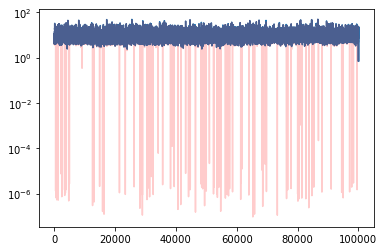

In [22]:
plt.plot(np.hstack([np.abs(output[fr+1]["scores_brute"]) for fr,_ in enumerate(stream_files)]))
plt.plot(np.hstack([np.abs(output[fr+1]["scores_local"]) for fr,_ in enumerate(stream_files)]), "r-",alpha=0.2)
#plt.plot(np.hstack([indexxxabble[fr+1] for fr,_ in enumerate(stream_files)]), "k-",alpha=0.3)

#plt.plot(np.abs(output[1]["scores_elim"]), "r-")
plt.yscale('log')

In [23]:
indexxxabble = {}
for i, file in tqdm(enumerate(stream_files)):
    stream_lyso_Greta = streamfile_parser(file)
    indxable = np.zeros(len(stream_lyso_Greta.parsed),dtype=int)
    if len(stream_lyso_Greta.get_indexable_frames())>0:
        indxable[stream_lyso_Greta.get_indexable_frames()]=150
    indexxxabble[i+1]=indxable

/tmp/ipykernel_32591/558922573.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, file in tqdm(enumerate(stream_files)):


0it [00:00, ?it/s]

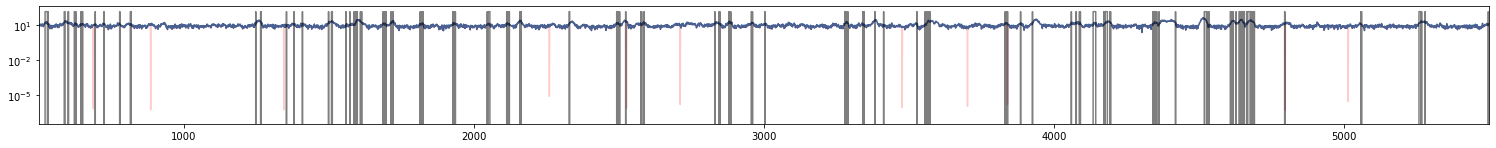

In [36]:
plt.figure(figsize=(26,18))
plt.axes().set_aspect(40)
plt.plot(np.hstack([np.abs(output[fr+1]["scores_brute"]) for fr,_ in enumerate(stream_files)]))
plt.plot(np.hstack([np.abs(output[fr+1]["scores_local"]) for fr,_ in enumerate(stream_files)]), "r-",alpha=0.2)
plt.plot(np.hstack([indexxxabble[fr+1] for fr,_ in enumerate(stream_files)]), "k-",alpha=0.5)

plt.xlim(500,5500)

#plt.plot(np.abs(output[1]["scores_elim"]), "r-")
plt.yscale('log')

In [37]:
srsss=np.hstack([np.abs(output[fr+1]["scores_brute"]) for fr,_ in enumerate(stream_files)])
sridx=np.hstack([indexxxabble[fr+1] for fr,_ in enumerate(stream_files)])
idrsy=np.where(sridx>0)[0]
srsss=srsss[idrsy]
sridx=sridx[idrsy]
srsssn=np.hstack([np.abs(output[fr+1]["scores_brute"]) for fr,_ in enumerate(stream_files)])
sridxn=np.hstack([indexxxabble[fr+1] for fr,_ in enumerate(stream_files)])
idrsn=np.where(sridxn==0)[0]
srsssn=np.clip(srsssn,0,50)[idrsn]
sridxn=sridxn[idrsn]

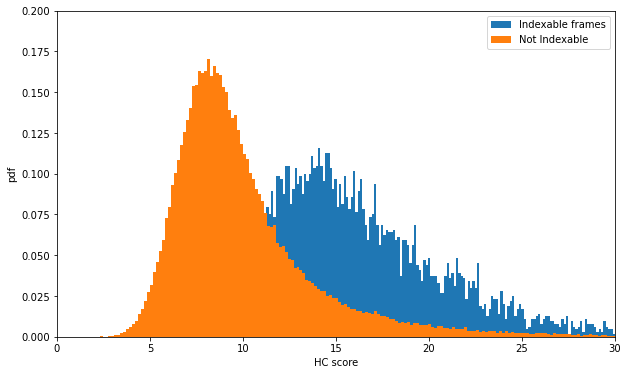

In [38]:
plt.figure(figsize=(10,6))
_=plt.hist(srsss,bins=300,density=True,label='Indexable frames')
_=plt.hist(srsssn,bins=300,density=True,label='Not Indexable')
#plt.yscale('log')
plt.ylim(0,0.2)
plt.xlim(0,30)
plt.xlabel("HC score")
plt.ylabel("pdf")
plt.legend()